<a href="https://colab.research.google.com/github/andysontran/13-CHL5230-F23/blob/main/stroke_pred_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# CHL5230H (F23): Datathon 2 - Early Prediction of Heart Failure
# Team Members:
#   No_13:  Katherine Lu  Amanda Rahmadian  Son Tran

# Dataset Used:
#   Cardiovascular Event Dataset (dataset.csv)
#     Attribute	Description:
#       id	Unique identifier
#       gender	“Male”, “Female” or “Other”
#       age	Age of the patient
#       hypertension	0 if the patient doesn’t have hypertension, 1 if they do
#       heart_disease	0 if the patient doesn’t have any heart diseases, 1 if they do
#       ever_married	“No” or “Yes”
#       work_type	“Children”, “Govt_jov”, “Never_worked”, “Private” or “Self-employed”
#       Residence_type	“Rural” or “Urban”
#       avg_glucose_level	Average glucose level in blood
#       bmi	Body mass index
#       smoking_status	“Formerly smoked”, “Never smoked”, “Smokes” or “Unknown”*
#       stroke	1 if the patient had a stroke, 0 if not

# 1 File Input

In [97]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Clone files on Github repository to Drive
!git clone https://github.com/andysontran/13-CHL5230-F23.git

# Set working directory
%cd 13-CHL5230-F23/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cloning into '13-CHL5230-F23'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 37 (delta 16), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (37/37), 1.75 MiB | 7.78 MiB/s, done.
Resolving deltas: 100% (16/16), done.
/content/13-CHL5230-F23/13-CHL5230-F23/13-CHL5230-F23/13-CHL5230-F23/13-CHL5230-F23


In [98]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings

# Load the Cardiovascular Event Dataset into a Pandas df
import pandas as pd

data = pd.read_csv('Cardiovascular Event Dataset.csv')
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


# 2 Data Pre-processing and Exploratory Data Analysis

In [99]:
# Remove the id row
data.drop('id', axis=1, inplace=True)
data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


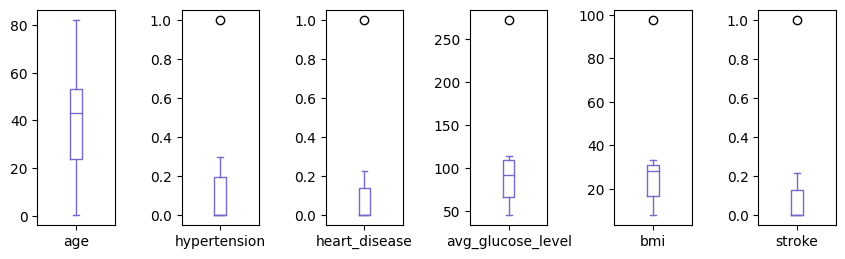

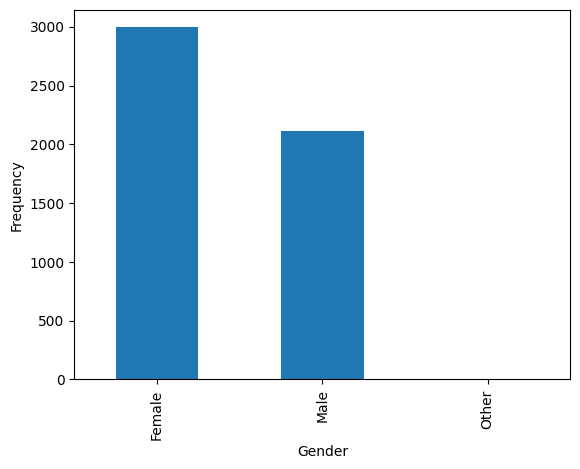

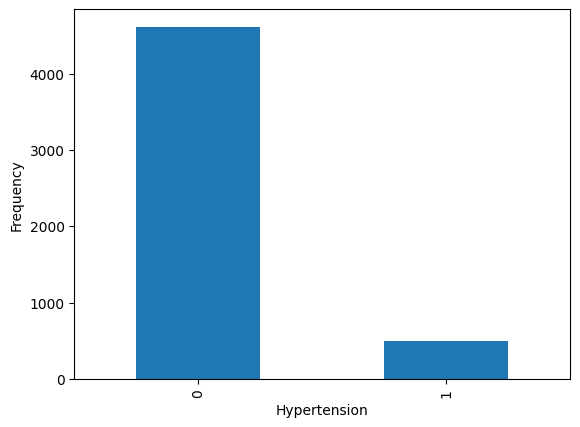

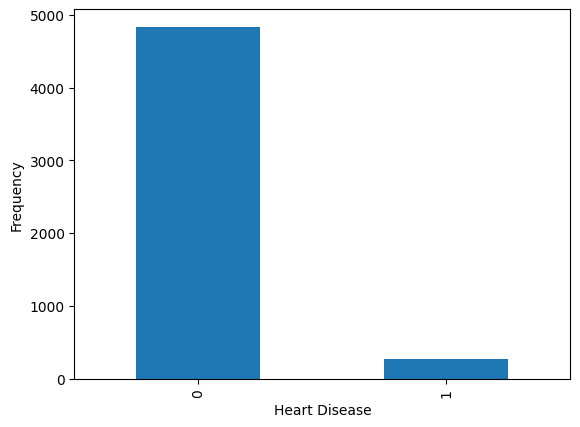

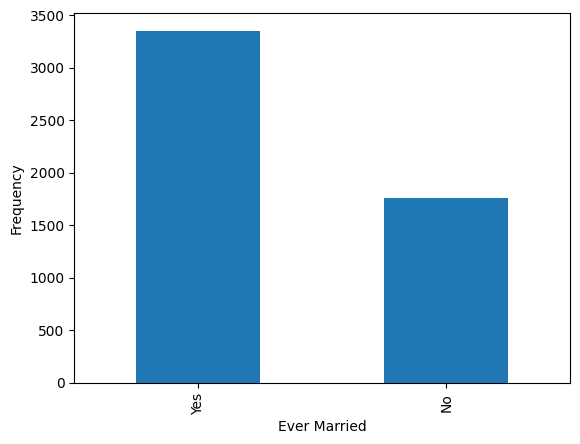

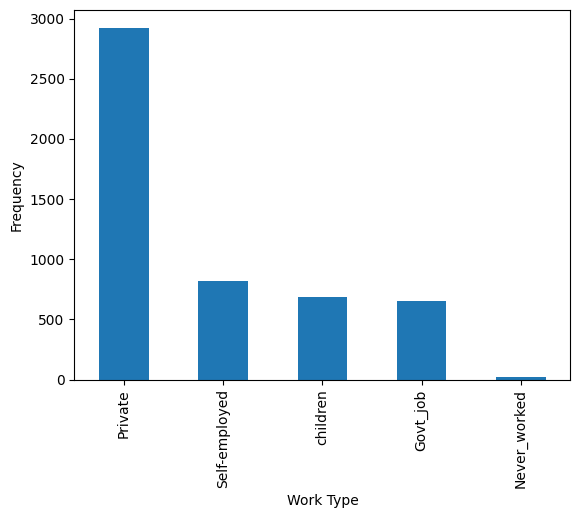

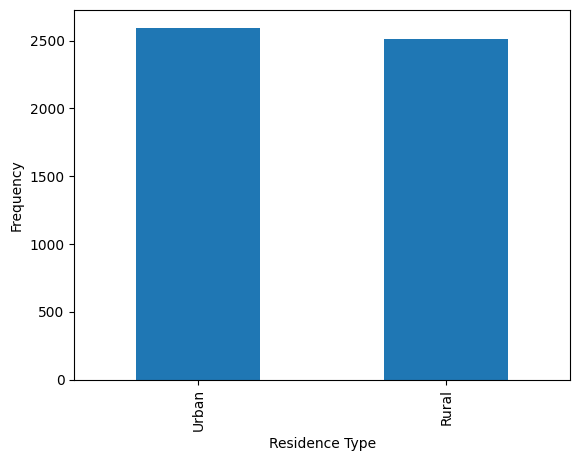

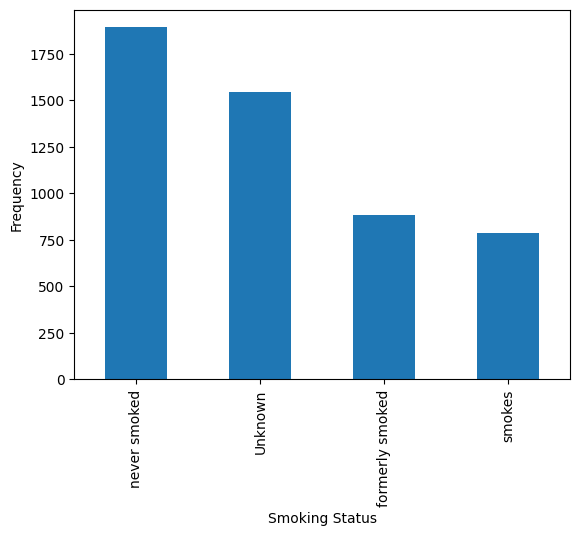

In [100]:
# Exploration of the dataset, dropping the 'count' row for better visualization
description = data.describe()
description
description = description.drop('count')

# Plot some graphs to visually show data distribution

# Box and whisker plots (only looking at continuous variables)
description.plot(kind='box', subplots=True, layout=(2, 7), figsize=(10, 5),
                 color='#7569c9')
plt.tight_layout()
plt.show()

# Bar graphs (for categorical variables)
data['gender'].value_counts().plot(kind='bar')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.show()
data['hypertension'].value_counts().plot(kind='bar')
plt.xlabel('Hypertension')
plt.ylabel('Frequency')
plt.show()
data['heart_disease'].value_counts().plot(kind='bar')
plt.xlabel('Heart Disease')
plt.ylabel('Frequency')
plt.show()
data['ever_married'].value_counts().plot(kind='bar')
plt.xlabel('Ever Married')
plt.ylabel('Frequency')
plt.show()
data['work_type'].value_counts().plot(kind='bar')
plt.xlabel('Work Type')
plt.ylabel('Frequency')
plt.show()
data['Residence_type'].value_counts().plot(kind='bar')
plt.xlabel('Residence Type')
plt.ylabel('Frequency')
plt.show()
data['smoking_status'].value_counts().plot(kind='bar')
plt.xlabel('Smoking Status')
plt.ylabel('Frequency')
plt.show()

<Axes: >

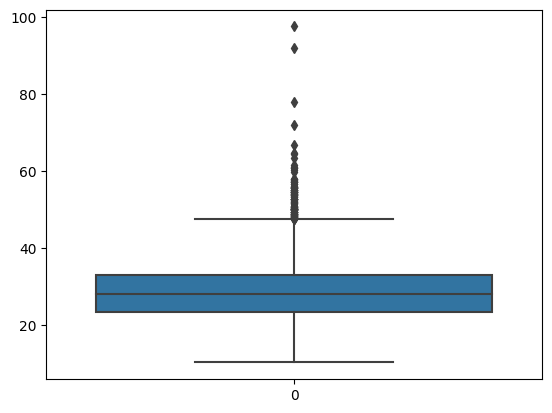

In [101]:
# Box plot of 'bmi'
sns.boxplot(data['bmi'])

<Axes: >

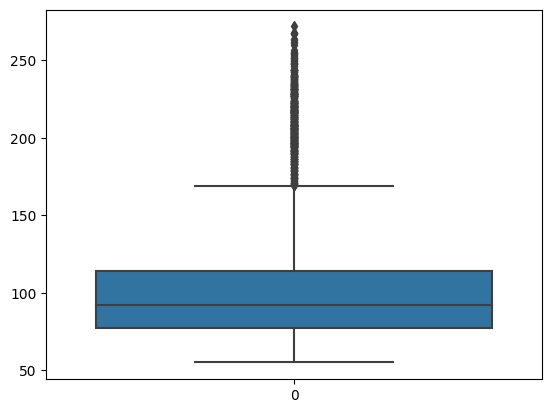

In [102]:
# Box plot of 'avg_glucose_level'
sns.boxplot(data['avg_glucose_level'])

In [103]:
# Since gender=Other only has 1 observation in the dataset, we decided to drop
# this row from our analysis
data.drop(3116,axis=0,inplace=True)

In [104]:
# Code the binary variables gender, ever_married, Residence_type into numerical values;
data['gender'] = data['gender'].map({'Male': 0, 'Female': 1})
data['ever_married'] = data['ever_married'].map({'No': 0, 'Yes': 1})
data['Residence_type'] = data['Residence_type'].map({'Rural': 0, 'Urban': 1})

In [105]:
# Since children in the dataset skew age and BMI (and as BMI is not as accurate for youth), we decided to restrict our models to adults only, so remove work_type=children
data = data[data.work_type != 'children']

# and remove anyone under age 18
data = data[data.age >= 18]

In [106]:
# Create one-hot coding for work_type
data['work_type_Private'] = np.where(data['work_type']=='Private', 1, 0)
data['work_type_Selfemployed'] = np.where(data['work_type']=='Self-employed', 1, 0)
data['work_type_Govtjob'] = np.where(data['work_type']=='Govt_job', 1, 0)
data['work_type_Never'] = np.where(data['work_type']=='Never_worked', 1, 0)
data.drop ('work_type', axis=1, inplace=True)

In [107]:
# Create one-hot coding for smoking
data['smoking_status_Former'] = np.where(data['smoking_status']=='formerly smoked', 1, 0)
data['smoking_status_Never'] = np.where(data['smoking_status']=='never smoked', 1, 0)
data['smoking_status_Smokes'] = np.where(data['smoking_status']=='smokes', 1, 0)
data['smoking_status_Unknown'] = np.where(data['smoking_status']=='Unknown', 1, 0)
data.drop ('smoking_status', axis=1, inplace=True)

In [108]:
# Check for missing values in each column
print(data.isnull().sum())

gender                      0
age                         0
hypertension                0
heart_disease               0
ever_married                0
Residence_type              0
avg_glucose_level           0
bmi                       181
stroke                      0
work_type_Private           0
work_type_Selfemployed      0
work_type_Govtjob           0
work_type_Never             0
smoking_status_Former       0
smoking_status_Never        0
smoking_status_Smokes       0
smoking_status_Unknown      0
dtype: int64


In [109]:
# For BMI, replace zeros with nan to handle missing values
data[['bmi']] = data[['bmi']].replace(0, np.nan)

# Fill missing values with median
data.fillna(data.median(), inplace=True)

# Check to see if there are no more missing values
print(data.isnull().sum())

gender                    0
age                       0
hypertension              0
heart_disease             0
ever_married              0
Residence_type            0
avg_glucose_level         0
bmi                       0
stroke                    0
work_type_Private         0
work_type_Selfemployed    0
work_type_Govtjob         0
work_type_Never           0
smoking_status_Former     0
smoking_status_Never      0
smoking_status_Smokes     0
smoking_status_Unknown    0
dtype: int64


In [110]:
# Explore dataset again, after pre-processing of data
description = data.describe()
description

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Private,work_type_Selfemployed,work_type_Govtjob,work_type_Never,smoking_status_Former,smoking_status_Never,smoking_status_Smokes,smoking_status_Unknown
count,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.00000,4253.000000
mean,0.605690,50.207853,0.116859,0.064660,0.788385,0.509993,108.506207,30.382177,0.058077,0.656008,0.189748,0.153068,0.001176,0.201975,0.411945,0.18340,0.202680
std,0.488759,17.827267,0.321290,0.245954,0.408502,0.499959,47.772032,7.083660,0.233916,0.475094,0.392148,0.360096,0.034271,0.401521,0.492243,0.38704,0.402044
min,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,55.120000,11.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,36.000000,0.000000,0.000000,1.000000,0.000000,77.480000,25.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,1.000000,51.000000,0.000000,0.000000,1.000000,1.000000,92.440000,29.200000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,1.000000,64.000000,0.000000,0.000000,1.000000,1.000000,116.120000,33.800000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000
max,1.000000,82.000000,1.000000,1.000000,1.000000,1.000000,271.740000,92.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


<Axes: >

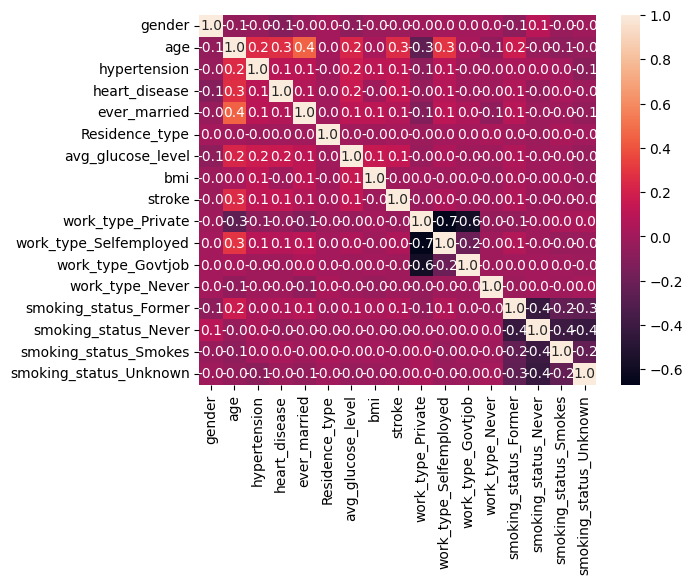

In [111]:
# Correlation matrix to quantify relationships (this might not be super helpful
# for us, since we have so many categorical variables. i think we should just
# fix for collinearity using L1 or L2
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".1f")
# For the continuous variables, they don't seem to be heavily correlated with
# each other

# 3.1 ML Analysis (Pre-processed Data)

**3.1.1 Implement K-NN**

In [112]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Split data into features and label for feature importance
##  Features: gender	age	hypertension	heart_disease	ever_married	Residence_type
##            avg_glucose_level	bmi	work_type_Private	work_type_Selfemployed
##            work_type_Govtjob	work_type_Never smoking_status_Former
##            smoking_status_Never  smoking_status_Smokes smoking_status_Unknown
##  Label:    stroke

## CONSTANTS
X = data[['gender','age','hypertension','heart_disease','ever_married',
            'Residence_type','avg_glucose_level','bmi','work_type_Private',
            'work_type_Selfemployed','work_type_Govtjob','work_type_Never',
            'smoking_status_Former','smoking_status_Never','smoking_status_Smokes',
            'smoking_status_Unknown']]
y = data['stroke']
# Test size used
size = 0.2
# Data balancing method used
data_bal_met = 'none'
##

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = size,
                                                    random_state = 42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Feature: gender, Score: 0.01790
Feature: age, Score: 0.21178
Feature: hypertension, Score: 0.03016
Feature: heart_disease, Score: 0.01860
Feature: ever_married, Score: 0.01328
Feature: Residence_type, Score: 0.02942
Feature: avg_glucose_level, Score: 0.32621
Feature: bmi, Score: 0.23004
Feature: work_type_Private, Score: 0.02466
Feature: work_type_Selfemployed, Score: 0.01742
Feature: work_type_Govtjob, Score: 0.00461
Feature: work_type_Never, Score: 0.00000
Feature: smoking_status_Former, Score: 0.01791
Feature: smoking_status_Never, Score: 0.02031
Feature: smoking_status_Smokes, Score: 0.01668
Feature: smoking_status_Unknown, Score: 0.02102


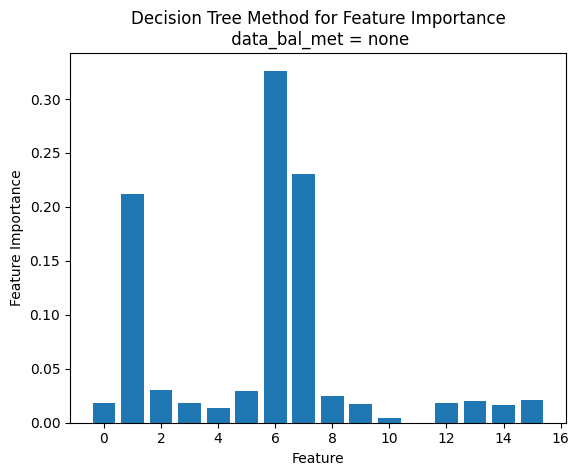

In [113]:
# Decision tree for feature importance
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier

# Define the model
model = DecisionTreeClassifier()
# Fit the model
model.fit(X_train, y_train)
# Get importance
importance = model.feature_importances_
# Summarize feature importance
for count, value in enumerate(importance):
  print('Feature: ' + X.columns[count] + ', Score: %.5f' % value)
# Plot feature importance
plt.bar([x for x in range(len(importance))], importance)
title = 'Decision Tree Method for Feature Importance\n data_bal_met = ' + data_bal_met
plt.title(title)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.show()

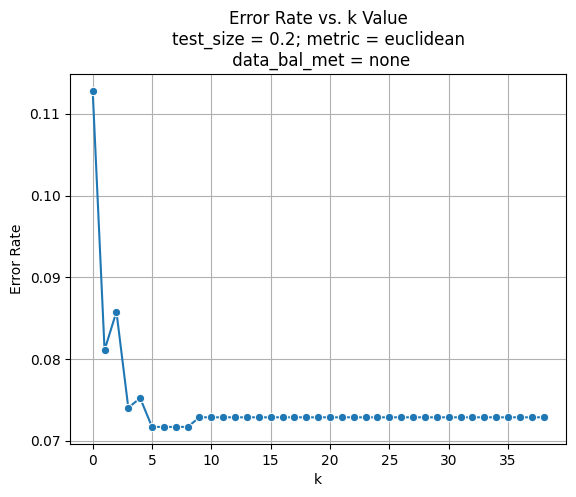

In [114]:
## CONSTANTS
# Test size used
size = 0.2
# Distance metric used
met = 'euclidean'
##

# Check error rate for k = 1 to 40
error_rate = []

for k in range(1, 40):
  knn = KNeighborsClassifier(n_neighbors = k, metric = met)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  error_rate.append(1 - accuracy_score(y_test, y_pred))

# Plot line graph of error rate
sns.lineplot(error_rate, marker = 'o')
plt.grid(True)
plt.xlabel('k')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. k Value\ntest_size = ' + str(size) + '; metric = ' + met + '\n data_bal_met = ' + data_bal_met)
plt.show()

[[776  13]
 [ 60   2]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       789
           1       0.13      0.03      0.05        62

    accuracy                           0.91       851
   macro avg       0.53      0.51      0.50       851
weighted avg       0.87      0.91      0.89       851



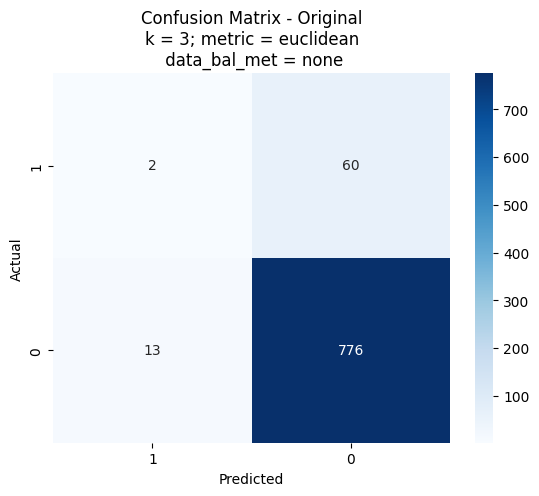

In [115]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# K value used
k = 3

# Initialize K-NN classifier and fit the model
knn = KNeighborsClassifier(n_neighbors = k, metric = met)
knn.fit(X_train, y_train)

# Predict using test data
y_pred = knn.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Visualize K-NN results using confusion matrix heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Get unique classes
classes = data['stroke'].unique()

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred, labels = classes), annot = True,
            xticklabels = classes, yticklabels = classes, cmap = 'Blues',
            fmt = 'g')

plt.xlabel('Predicted')
plt.ylabel('Actual')
title = 'Confusion Matrix - Original\nk = ' + str(k) + '; metric = ' + met + '\n data_bal_met = ' + data_bal_met
plt.title(title)

plt.show()

Feature: gender, Score: -0.00400
Feature: age, Score: -0.00071
Feature: hypertension, Score: -0.00282
Feature: heart_disease, Score: 0.00024
Feature: ever_married, Score: -0.00047
Feature: Residence_type, Score: -0.00235
Feature: avg_glucose_level, Score: 0.00094
Feature: bmi, Score: -0.00423
Feature: work_type_Private, Score: -0.00071
Feature: work_type_Selfemployed, Score: -0.00188
Feature: work_type_Govtjob, Score: -0.00024
Feature: work_type_Never, Score: 0.00000
Feature: smoking_status_Former, Score: -0.00353
Feature: smoking_status_Never, Score: 0.00000
Feature: smoking_status_Smokes, Score: -0.00400
Feature: smoking_status_Unknown, Score: -0.00212


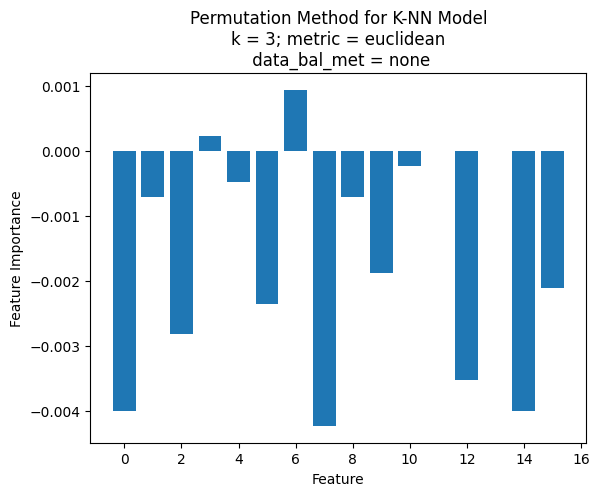

In [116]:
# Permutation for feature importance with K-NN for classification
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

# Fit the model
results = permutation_importance(knn, X_test, y_test, scoring = 'accuracy')
# Get importance
importance = results.importances_mean
# Summarize feature importance
for count,value in enumerate(importance):
  print('Feature: ' + X.columns[count] + ', Score: %.5f' % value)
# Plot feature importance
plt.bar([x for x in range(len(importance))], importance)
title = 'Permutation Method for K-NN Model\nk = ' + str(k) + '; metric = ' + met + '\n data_bal_met = ' + data_bal_met
plt.title(title)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.show()

**3.1.2 Implement Logistic Regression**

In [117]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Split data into features and label for feature importance
##  Features: gender	age	hypertension	heart_disease	ever_married	Residence_type
##            avg_glucose_level	bmi	work_type_Private	work_type_Selfemployed
##            work_type_Govtjob	work_type_Never smoking_status_Former
##            smoking_status_Never  smoking_status_Smokes smoking_status_Unknown
##  Label:    stroke

## CONSTANTS
X = data_up[['gender','age','hypertension','heart_disease','ever_married',
            'Residence_type','avg_glucose_level','bmi','work_type_Private',
            'work_type_Selfemployed','work_type_Govtjob','work_type_Never',
            'smoking_status_Former','smoking_status_Never','smoking_status_Smokes',
            'smoking_status_Unknown']]
y = data_up['stroke']
# Test size used
size = 0.2
# Data balancing method used
data_bal_met = 'Upsampling'
##

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = size,
                                                    random_state = 42)

# Normalizing data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [118]:
## CONSTANTS
pen = 'l1'
reg = 1.0
solv = 'liblinear'
##

# Training logistic regression model
log_reg = LogisticRegression(penalty=pen, C=reg, solver=solv)
  #L1 to help with feature selection
  #C=1 is moderate regularization
  #liblinear is good for binary outcomes
log_reg.fit(X_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.68      0.72       819
         1.0       0.70      0.79      0.74       784

    accuracy                           0.73      1603
   macro avg       0.73      0.73      0.73      1603
weighted avg       0.74      0.73      0.73      1603


Confusion Matrix:
[[557 262]
 [168 616]] 



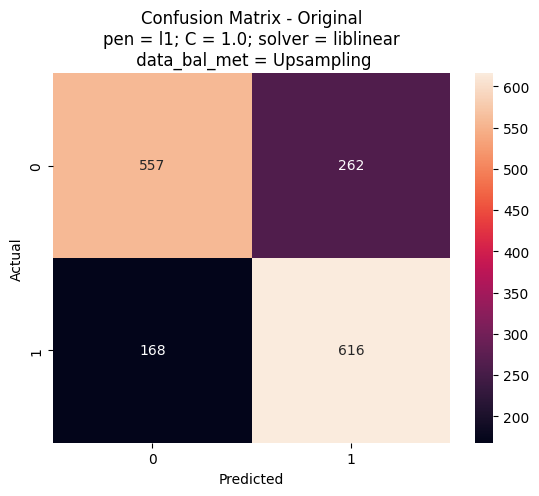

In [119]:
# Use the model to make predictions on the testing data
y_pred = log_reg.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Classification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix,"\n")

# Visualizing confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
title = 'Confusion Matrix - Original\npen = ' + pen + '; C = ' + str(reg) + '; solver = ' + solv + '\n data_bal_met = ' + data_bal_met
plt.title(title)

plt.show()

In [120]:
## CONSTANTS
pen = 'l2'
reg = 1.0
solv = 'liblinear'
##

# Training logistic regression model, with L2 instead
log_reg = LogisticRegression(penalty=pen, C=reg, solver=solv)
  #L1 to help with feature selection
  #C=1 is moderate regularization
  #liblinear is good for binary outcomes
log_reg.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.68      0.72       819
         1.0       0.70      0.79      0.74       784

    accuracy                           0.73      1603
   macro avg       0.73      0.73      0.73      1603
weighted avg       0.74      0.73      0.73      1603


Confusion Matrix:
[[557 262]
 [168 616]] 



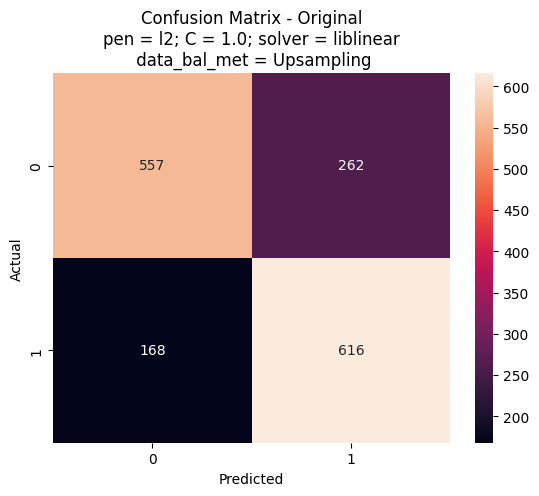

In [121]:
# Use the model to make predictions on the testing data
y_pred = log_reg.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Classification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix,"\n")

# Visualizing confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
title = 'Confusion Matrix - Original\npen = ' + pen + '; C = ' + str(reg) + '; solver = ' + solv + '\n data_bal_met = ' + data_bal_met
plt.title(title)

plt.show()

In [122]:
### model summary

import statsmodels.api as sm
import pandas as pd

# Separate features and target variable
X = data.drop('stroke', axis=1)
y = data['stroke']

# Add a constant term for the intercept
X = sm.add_constant(X)

# Create and fit logistic regression model
log_reg = sm.Logit(y, X).fit()

# Get summary report
summary = log_reg.summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.182526
         Iterations 26
                           Logit Regression Results                           
Dep. Variable:                 stroke   No. Observations:                 4253
Model:                          Logit   Df Residuals:                     4238
Method:                           MLE   Df Model:                           14
Date:                Mon, 02 Oct 2023   Pseudo R-squ.:                  0.1765
Time:                        16:31:30   Log-Likelihood:                -776.28
converged:                       True   LL-Null:                       -942.64
Covariance Type:            nonrobust   LLR p-value:                 1.720e-62
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -10.4622        nan        nan        nan         nan     

# 3.2 ML Analysis (Data Balancing by Random Upsampling)

**3.2.1 Data Balancing by Random Upsampling**

In [123]:
data_0 = data[data['stroke'] == 0]
data_1 = data[data['stroke'] == 1]

data['stroke'].value_counts()

0    4006
1     247
Name: stroke, dtype: int64

In [124]:
# Import necessary library
from sklearn.utils import resample

data_1 = resample(data_1, replace = True, n_samples = data_0.shape[0],
                  random_state = 123)

In [125]:
print(data_1.shape)

(4006, 17)


In [126]:
# Concatenate upsampled data
data_up = np.concatenate((data_0, data_1))

# Create the balanced df
data_up = pd.DataFrame(data_up)
data_up.columns = list(data.columns)

In [127]:
data_up['stroke'].value_counts()

0.0    4006
1.0    4006
Name: stroke, dtype: int64

**3.2.2 Implement K-NN**

In [128]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Split data into features and label for feature importance
##  Features: gender	age	hypertension	heart_disease	ever_married	Residence_type
##            avg_glucose_level	bmi	work_type_Private	work_type_Selfemployed
##            work_type_Govtjob	work_type_Never smoking_status_Former
##            smoking_status_Never  smoking_status_Smokes smoking_status_Unknown
##  Label:    stroke

## CONSTANTS
X = data_up[['gender','age','hypertension','heart_disease','ever_married',
            'Residence_type','avg_glucose_level','bmi','work_type_Private',
            'work_type_Selfemployed','work_type_Govtjob','work_type_Never',
            'smoking_status_Former','smoking_status_Never','smoking_status_Smokes',
            'smoking_status_Unknown']]
y = data_up['stroke']
# Test size used
size = 0.2
# Data balancing method used
data_bal_met = 'Rand_upsampling'
##

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = size,
                                                    random_state = 42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Feature: gender, Score: 0.01127
Feature: age, Score: 0.42508
Feature: hypertension, Score: 0.01766
Feature: heart_disease, Score: 0.00733
Feature: ever_married, Score: 0.00824
Feature: Residence_type, Score: 0.01078
Feature: avg_glucose_level, Score: 0.20081
Feature: bmi, Score: 0.21439
Feature: work_type_Private, Score: 0.02601
Feature: work_type_Selfemployed, Score: 0.00729
Feature: work_type_Govtjob, Score: 0.00774
Feature: work_type_Never, Score: 0.00000
Feature: smoking_status_Former, Score: 0.00476
Feature: smoking_status_Never, Score: 0.02980
Feature: smoking_status_Smokes, Score: 0.01572
Feature: smoking_status_Unknown, Score: 0.01314


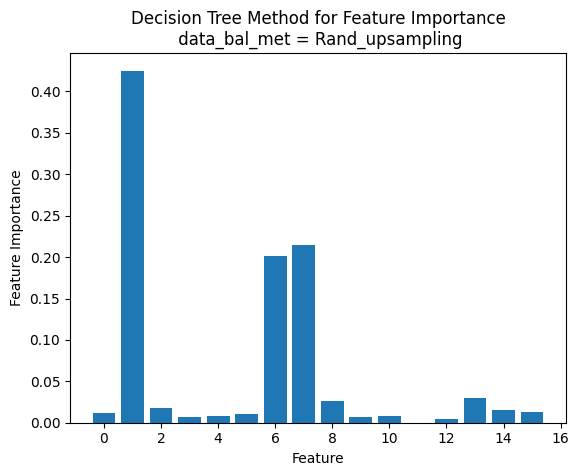

In [129]:
# Decision tree for feature importance
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier

# Define the model
model = DecisionTreeClassifier()
# Fit the model
model.fit(X_train, y_train)
# Get importance
importance = model.feature_importances_
# Summarize feature importance
for count, value in enumerate(importance):
  print('Feature: ' + X.columns[count] + ', Score: %.5f' % value)
# Plot feature importance
plt.bar([x for x in range(len(importance))], importance)
title = 'Decision Tree Method for Feature Importance\n data_bal_met = ' + data_bal_met
plt.title(title)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.show()

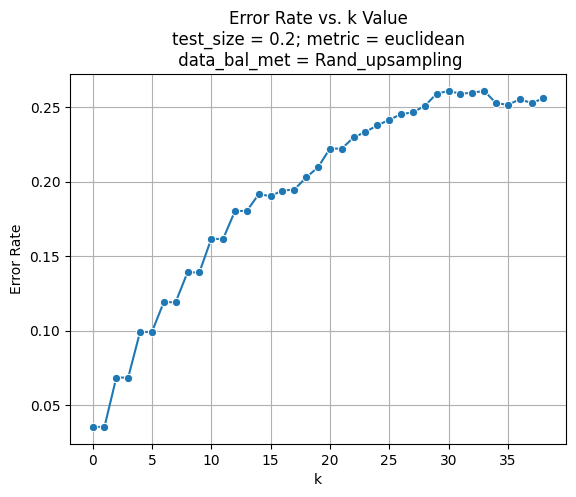

In [130]:
## CONSTANTS
# Test size used
size = 0.2
# Distance metric used
met = 'euclidean'
##

# Check error rate for k = 1 to 40
error_rate = []

for k in range(1, 40):
  knn = KNeighborsClassifier(n_neighbors = k, metric = met)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  error_rate.append(1 - accuracy_score(y_test, y_pred))

# Plot line graph of error rate
sns.lineplot(error_rate, marker = 'o')
plt.grid(True)
plt.xlabel('k')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. k Value\ntest_size = ' + str(size) + '; metric = ' + met + '\n data_bal_met = ' + data_bal_met)
plt.show()

[[709 110]
 [  0 784]]
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93       819
         1.0       0.88      1.00      0.93       784

    accuracy                           0.93      1603
   macro avg       0.94      0.93      0.93      1603
weighted avg       0.94      0.93      0.93      1603



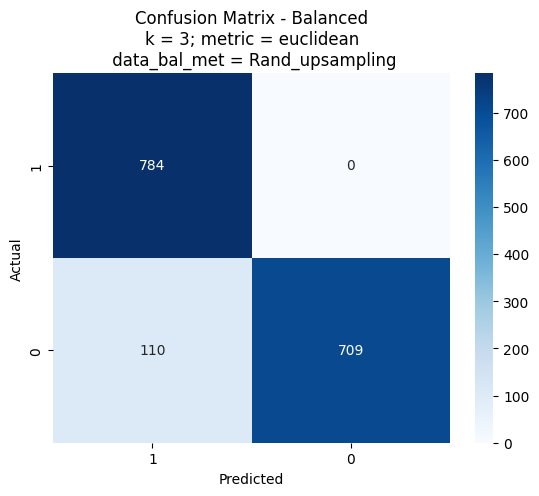

In [131]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# K value used
k = 3

# Initialize K-NN classifier and fit the model
knn = KNeighborsClassifier(n_neighbors = k, metric = met)
knn.fit(X_train, y_train)

# Predict using test data
y_pred = knn.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Visualize K-NN results using confusion matrix heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Get unique classes
classes = data['stroke'].unique()

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred, labels = classes), annot = True,
            xticklabels = classes, yticklabels = classes, cmap = 'Blues',
            fmt = 'g')

plt.xlabel('Predicted')
plt.ylabel('Actual')
title = 'Confusion Matrix - Balanced\nk = ' + str(k) + '; metric = ' + met + '\n data_bal_met = ' + data_bal_met
plt.title(title)

plt.show()

Feature: gender, Score: 0.13712
Feature: age, Score: 0.21023
Feature: hypertension, Score: 0.11067
Feature: heart_disease, Score: 0.09420
Feature: ever_married, Score: 0.06276
Feature: Residence_type, Score: 0.14198
Feature: avg_glucose_level, Score: 0.18403
Feature: bmi, Score: 0.15933
Feature: work_type_Private, Score: 0.00037
Feature: work_type_Selfemployed, Score: 0.08696
Feature: work_type_Govtjob, Score: 0.07099
Feature: work_type_Never, Score: 0.00025
Feature: smoking_status_Former, Score: 0.07748
Feature: smoking_status_Never, Score: -0.00150
Feature: smoking_status_Smokes, Score: 0.08309
Feature: smoking_status_Unknown, Score: 0.06101


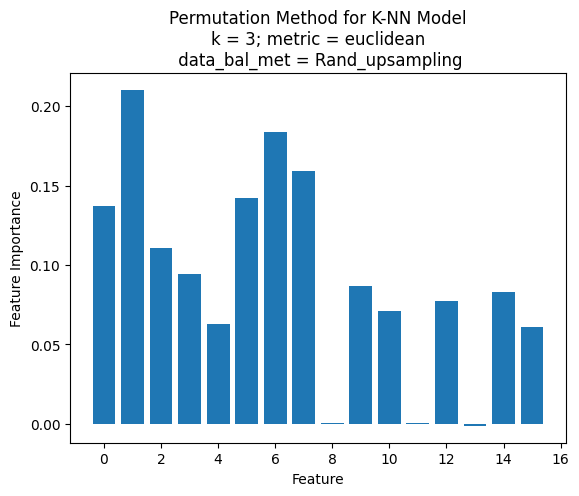

In [132]:
# Permutation for feature importance with K-NN for classification
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

# Fit the model
results = permutation_importance(knn, X_test, y_test, scoring = 'accuracy')
# Get importance
importance = results.importances_mean
# Summarize feature importance
for count,value in enumerate(importance):
  print('Feature: ' + X.columns[count] + ', Score: %.5f' % value)
# Plot feature importance
plt.bar([x for x in range(len(importance))], importance)
title = 'Permutation Method for K-NN Model\nk = ' + str(k) + '; metric = ' + met + '\n data_bal_met = ' + data_bal_met
plt.title(title)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.show()

[[1779 2227]
 [  82  165]]
              precision    recall  f1-score   support

           0       0.96      0.44      0.61      4006
           1       0.07      0.67      0.13       247

    accuracy                           0.46      4253
   macro avg       0.51      0.56      0.37      4253
weighted avg       0.90      0.46      0.58      4253



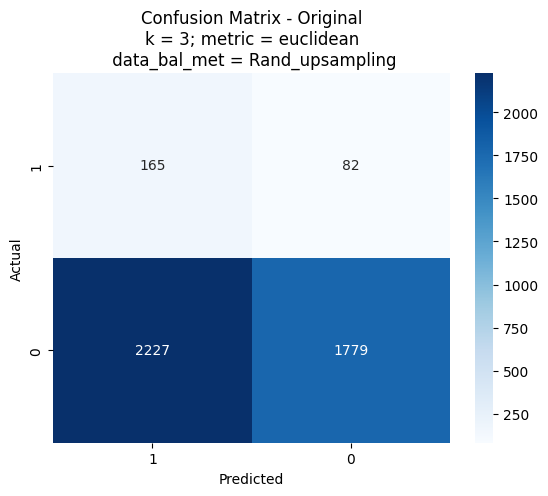

In [133]:
# Evaluate on original data
X_orig = data[['gender','age','hypertension','heart_disease','ever_married',
            'Residence_type','avg_glucose_level','bmi','work_type_Private',
            'work_type_Selfemployed','work_type_Govtjob','work_type_Never',
            'smoking_status_Former','smoking_status_Never','smoking_status_Smokes',
            'smoking_status_Unknown']]
y_orig = data['stroke']

X_orig_test = scaler.transform(X_orig)
y_orig_pred = knn.predict(X_orig_test)

# Evaluate the model
print(confusion_matrix(y_orig, y_orig_pred))
print(classification_report(y_orig, y_orig_pred))

# Visualize K-NN results using confusion matrix heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Get unique classes
classes = data['stroke'].unique()

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_orig, y_orig_pred, labels = classes), annot = True,
            xticklabels = classes, yticklabels = classes, cmap = 'Blues',
            fmt = 'g')

plt.xlabel('Predicted')
plt.ylabel('Actual')
title = 'Confusion Matrix - Original\nk = ' + str(k) + '; metric = ' + met + '\n data_bal_met = ' + data_bal_met
plt.title(title)

plt.show()

**3.3.3 Implement Logistic Regression**

In [134]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Split data into features and label for feature importance
##  Features: gender	age	hypertension	heart_disease	ever_married	Residence_type
##            avg_glucose_level	bmi	work_type_Private	work_type_Selfemployed
##            work_type_Govtjob	work_type_Never smoking_status_Former
##            smoking_status_Never  smoking_status_Smokes smoking_status_Unknown
##  Label:    stroke

## CONSTANTS
X = data_up[['gender','age','hypertension','heart_disease','ever_married',
            'Residence_type','avg_glucose_level','bmi','work_type_Private',
            'work_type_Selfemployed','work_type_Govtjob','work_type_Never',
            'smoking_status_Former','smoking_status_Never','smoking_status_Smokes',
            'smoking_status_Unknown']]
y = data_up['stroke']
# Test size used
size = 0.2
# Data balancing method used
data_bal_met = 'Upsampling'
##

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = size,
                                                    random_state = 42)

# Normalizing data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [135]:
## CONSTANTS
pen = 'l1'
reg = 1.0
solv = 'liblinear'
##

# Training logistic regression model
log_reg = LogisticRegression(penalty=pen, C=reg, solver=solv)
  #L1 to help with feature selection
  #C=1 is moderate regularization
  #liblinear is good for binary outcomes
log_reg.fit(X_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.68      0.72       819
         1.0       0.70      0.79      0.74       784

    accuracy                           0.73      1603
   macro avg       0.73      0.73      0.73      1603
weighted avg       0.74      0.73      0.73      1603


Confusion Matrix:
[[557 262]
 [168 616]] 



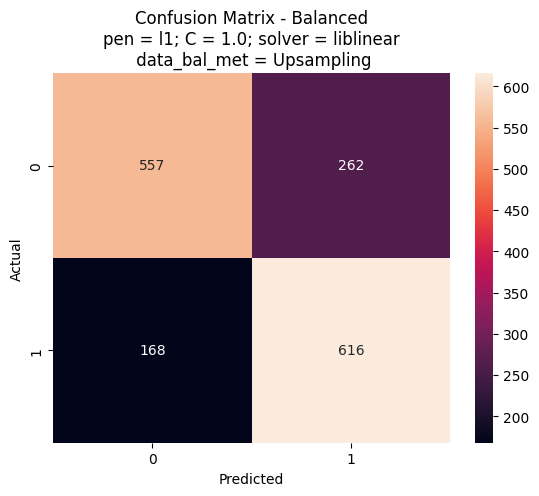

In [136]:
# Use the model to make predictions on the testing data
y_pred = log_reg.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Classification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix,"\n")

# Visualizing confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
title = 'Confusion Matrix - Balanced\npen = ' + pen + '; C = ' + str(reg) + '; solver = ' + solv + '\n data_bal_met = ' + data_bal_met
plt.title(title)

plt.show()

In [137]:
## CONSTANTS
pen = 'l2'
reg = 1.0
solv = 'liblinear'
##

# Training logistic regression model, with L2 instead
log_reg = LogisticRegression(penalty=pen, C=reg, solver=solv)
  #L1 to help with feature selection
  #C=1 is moderate regularization
  #liblinear is good for binary outcomes
log_reg.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.68      0.72       819
         1.0       0.70      0.79      0.74       784

    accuracy                           0.73      1603
   macro avg       0.73      0.73      0.73      1603
weighted avg       0.74      0.73      0.73      1603


Confusion Matrix:
[[557 262]
 [168 616]] 



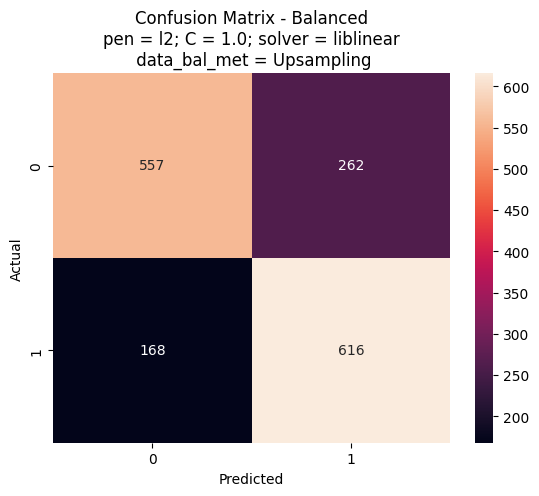

In [138]:
# Use the model to make predictions on the testing data
y_pred = log_reg.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Classification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix,"\n")

# Visualizing confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
title = 'Confusion Matrix - Balanced\npen = ' + pen + '; C = ' + str(reg) + '; solver = ' + solv + '\n data_bal_met = ' + data_bal_met
plt.title(title)

plt.show()

In [139]:
### model summary

import statsmodels.api as sm
import pandas as pd

# Separate features and target variable
X = data_up.drop('stroke', axis=1)
y = data_up['stroke']

# Add a constant term for the intercept
X = sm.add_constant(X)

# Create and fit logistic regression model
log_reg = sm.Logit(y, X).fit()

# Get summary report
summary = log_reg.summary()
print(summary)

         Current function value: 0.512429
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 stroke   No. Observations:                 8012
Model:                          Logit   Df Residuals:                     7996
Method:                           MLE   Df Model:                           15
Date:                Mon, 02 Oct 2023   Pseudo R-squ.:                  0.2607
Time:                        16:31:58   Log-Likelihood:                -4105.6
converged:                      False   LL-Null:                       -5553.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -6.1920        nan        nan        nan         nan         nan
gender                     0.

# 3.3 ML Analysis (Data Balancing by SMOTE)

**3.3.1 Data Balancing by SMOTE (Synthetic Minority Oversampling Technique)**

In [140]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
eval_data = data[['gender','age','hypertension','heart_disease','ever_married',
            'Residence_type','avg_glucose_level','bmi','work_type_Private',
            'work_type_Selfemployed','work_type_Govtjob','work_type_Never',
            'smoking_status_Former','smoking_status_Never','smoking_status_Smokes',
            'smoking_status_Unknown','stroke']].sample(int(data.shape[0]*0.2),
                                                       random_state = 42)
train_data = data.drop(index = eval_data.index)

X_eval, y_eval = eval_data[['gender','age','hypertension','heart_disease','ever_married',
            'Residence_type','avg_glucose_level','bmi','work_type_Private',
            'work_type_Selfemployed','work_type_Govtjob','work_type_Never',
            'smoking_status_Former','smoking_status_Never','smoking_status_Smokes',
            'smoking_status_Unknown']], eval_data['stroke']
X, y = train_data[['gender','age','hypertension','heart_disease','ever_married',
            'Residence_type','avg_glucose_level','bmi','work_type_Private',
            'work_type_Selfemployed','work_type_Govtjob','work_type_Never',
            'smoking_status_Former','smoking_status_Never','smoking_status_Smokes',
            'smoking_status_Unknown']], train_data['stroke']

X, y = oversample.fit_resample(X,y)
data_ups = X.assign(stroke = y)

In [141]:
data_ups['stroke'].value_counts()

1    3218
0    3218
Name: stroke, dtype: int64

**3.3.2 Implement K-NN**

In [142]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Split data into features and label for feature importance
##  Features: gender	age	hypertension	heart_disease	ever_married	Residence_type
##            avg_glucose_level	bmi	work_type_Private	work_type_Selfemployed
##            work_type_Govtjob	work_type_Never smoking_status_Former
##            smoking_status_Never  smoking_status_Smokes smoking_status_Unknown
##  Label:    stroke

## CONSTANTS
X = data_ups[['gender','age','hypertension','heart_disease','ever_married',
            'Residence_type','avg_glucose_level','bmi','work_type_Private',
            'work_type_Selfemployed','work_type_Govtjob','work_type_Never',
            'smoking_status_Former','smoking_status_Never','smoking_status_Smokes',
            'smoking_status_Unknown']]
y = data_ups['stroke']
# Test size used
size = 0.2
# Data balancing method used
data_bal_met = 'SMOTE'
##

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = size,
                                                    random_state = 42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Feature: gender, Score: 0.03359
Feature: age, Score: 0.35547
Feature: hypertension, Score: 0.01169
Feature: heart_disease, Score: 0.01140
Feature: ever_married, Score: 0.00805
Feature: Residence_type, Score: 0.01404
Feature: avg_glucose_level, Score: 0.09212
Feature: bmi, Score: 0.06671
Feature: work_type_Private, Score: 0.02532
Feature: work_type_Selfemployed, Score: 0.04843
Feature: work_type_Govtjob, Score: 0.03317
Feature: work_type_Never, Score: 0.00000
Feature: smoking_status_Former, Score: 0.07111
Feature: smoking_status_Never, Score: 0.06301
Feature: smoking_status_Smokes, Score: 0.06503
Feature: smoking_status_Unknown, Score: 0.10086


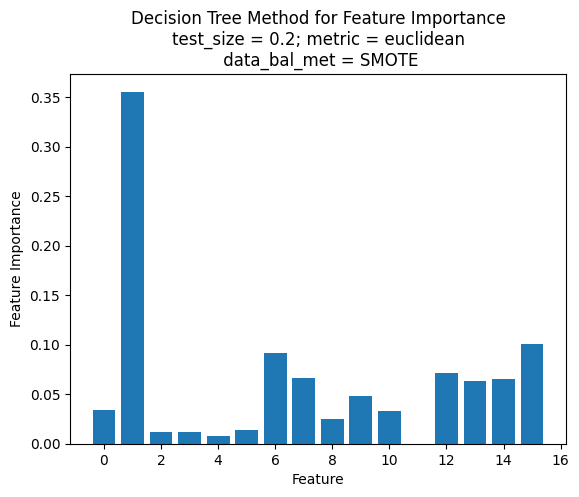

In [143]:
# Decision tree for feature importance
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier

# Define the model
model = DecisionTreeClassifier()
# Fit the model
model.fit(X_train, y_train)
# Get importance
importance = model.feature_importances_
# Summarize feature importance
for count, value in enumerate(importance):
  print('Feature: ' + X.columns[count] + ', Score: %.5f' % value)
# Plot feature importance
plt.bar([x for x in range(len(importance))], importance)
title = 'Decision Tree Method for Feature Importance\ntest_size = ' + str(size) + '; metric = ' + met + '\n data_bal_met = ' + data_bal_met
plt.title(title)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.show()

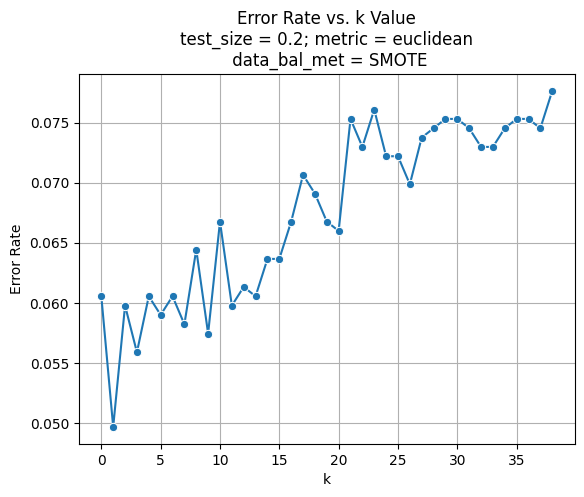

In [144]:
## CONSTANTS
# Test size used
size = 0.2
# Distance metric used
met = 'euclidean'
##

# Check error rate for k = 1 to 40
error_rate = []

for k in range(1, 40):
  knn = KNeighborsClassifier(n_neighbors = k, metric = met)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  error_rate.append(1 - accuracy_score(y_test, y_pred))

# Plot line graph of error rate
sns.lineplot(error_rate, marker = 'o')
plt.grid(True)
plt.xlabel('k')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. k Value\ntest_size = ' + str(size) + '; metric = ' + met + '\n data_bal_met = ' + data_bal_met)
plt.show()

[[600  41]
 [ 36 611]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       641
           1       0.94      0.94      0.94       647

    accuracy                           0.94      1288
   macro avg       0.94      0.94      0.94      1288
weighted avg       0.94      0.94      0.94      1288



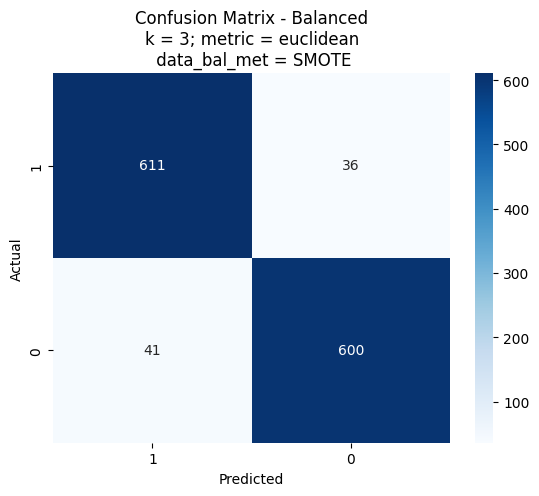

In [145]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# K value used
k = 3

# Initialize K-NN classifier and fit the model
knn = KNeighborsClassifier(n_neighbors = k, metric = met)
knn.fit(X_train, y_train)

# Predict using test data
y_pred = knn.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Visualize K-NN results using confusion matrix heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Get unique classes
classes = data['stroke'].unique()

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred, labels = classes), annot = True,
            xticklabels = classes, yticklabels = classes, cmap = 'Blues',
            fmt = 'g')

plt.xlabel('Predicted')
plt.ylabel('Actual')
title = 'Confusion Matrix - Balanced\nk = ' + str(k) + '; metric = ' + met + '\n data_bal_met = ' + data_bal_met
plt.title(title)

plt.show()

Feature: gender, Score: 0.01537
Feature: age, Score: 0.04441
Feature: hypertension, Score: 0.00497
Feature: heart_disease, Score: 0.00761
Feature: ever_married, Score: 0.00978
Feature: Residence_type, Score: 0.01009
Feature: avg_glucose_level, Score: 0.01755
Feature: bmi, Score: 0.01009
Feature: work_type_Private, Score: 0.08711
Feature: work_type_Selfemployed, Score: 0.05652
Feature: work_type_Govtjob, Score: 0.03804
Feature: work_type_Never, Score: 0.00016
Feature: smoking_status_Former, Score: 0.07112
Feature: smoking_status_Never, Score: 0.12096
Feature: smoking_status_Smokes, Score: 0.07857
Feature: smoking_status_Unknown, Score: 0.08012


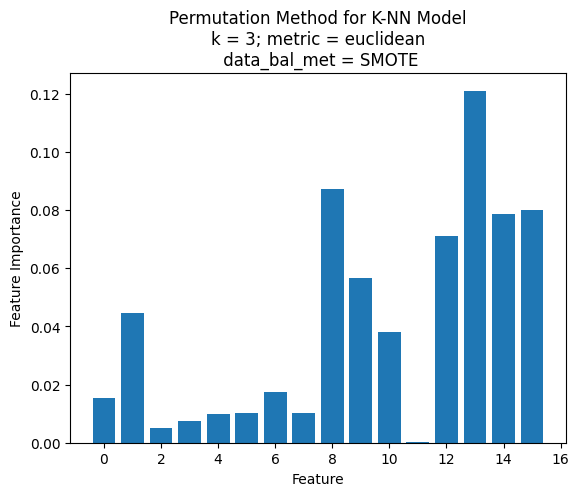

In [146]:
# Permutation for feature importance with K-NN for classification
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

# Fit the model
results = permutation_importance(knn, X_test, y_test, scoring = 'accuracy')
# Get importance
importance = results.importances_mean
# Summarize feature importance
for count,value in enumerate(importance):
  print('Feature: ' + X.columns[count] + ', Score: %.5f' % value)
# Plot feature importance
plt.bar([x for x in range(len(importance))], importance)
title = 'Permutation Method for K-NN Model\nk = ' + str(k) + '; metric = ' + met + '\n data_bal_met = ' + data_bal_met
plt.title(title)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.show()

[[1641 2365]
 [  77  170]]
              precision    recall  f1-score   support

           0       0.96      0.41      0.57      4006
           1       0.07      0.69      0.12       247

    accuracy                           0.43      4253
   macro avg       0.51      0.55      0.35      4253
weighted avg       0.90      0.43      0.55      4253



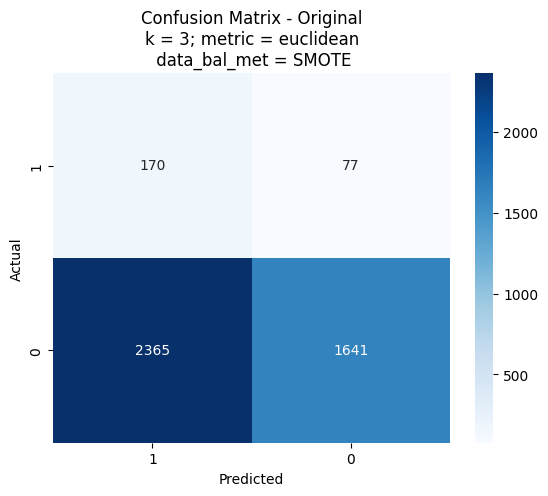

In [147]:
# Evaluate on original data
X_orig = data[['gender','age','hypertension','heart_disease','ever_married',
            'Residence_type','avg_glucose_level','bmi','work_type_Private',
            'work_type_Selfemployed','work_type_Govtjob','work_type_Never',
            'smoking_status_Former','smoking_status_Never','smoking_status_Smokes',
            'smoking_status_Unknown']]
y_orig = data['stroke']

X_orig_test = scaler.transform(X_orig)
y_orig_pred = knn.predict(X_orig_test)

# Evaluate the model
print(confusion_matrix(y_orig, y_orig_pred))
print(classification_report(y_orig, y_orig_pred))

# Visualize K-NN results using confusion matrix heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Get unique classes
classes = data['stroke'].unique()

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_orig, y_orig_pred, labels = classes), annot = True,
            xticklabels = classes, yticklabels = classes, cmap = 'Blues',
            fmt = 'g')

plt.xlabel('Predicted')
plt.ylabel('Actual')
title = 'Confusion Matrix - Original\nk = ' + str(k) + '; metric = ' + met + '\n data_bal_met = ' + data_bal_met
plt.title(title)

plt.show()

**3.3.3 Implement Logistic Regression**

In [148]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Split data into features and label for feature importance
##  Features: gender	age	hypertension	heart_disease	ever_married	Residence_type
##            avg_glucose_level	bmi	work_type_Private	work_type_Selfemployed
##            work_type_Govtjob	work_type_Never smoking_status_Former
##            smoking_status_Never  smoking_status_Smokes smoking_status_Unknown
##  Label:    stroke

## CONSTANTS
X = data_ups[['gender','age','hypertension','heart_disease','ever_married',
            'Residence_type','avg_glucose_level','bmi','work_type_Private',
            'work_type_Selfemployed','work_type_Govtjob','work_type_Never',
            'smoking_status_Former','smoking_status_Never','smoking_status_Smokes',
            'smoking_status_Unknown']]
y = data_ups['stroke']
# Test size used
size = 0.2
# Data balancing method used
data_bal_met = 'SMOTE'
##

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = size,
                                                    random_state = 42)

# Normalizing data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [149]:
## CONSTANTS
pen = 'l1'
reg = 1.0
solv = 'liblinear'
##

# Training logistic regression model
log_reg = LogisticRegression(penalty=pen, C=reg, solver=solv)
  #L1 to help with feature selection
  #C=1 is moderate regularization
  #liblinear is good for binary outcomes
log_reg.fit(X_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       641
           1       0.97      0.89      0.93       647

    accuracy                           0.93      1288
   macro avg       0.94      0.93      0.93      1288
weighted avg       0.94      0.93      0.93      1288


Confusion Matrix:
[[624  17]
 [ 68 579]] 



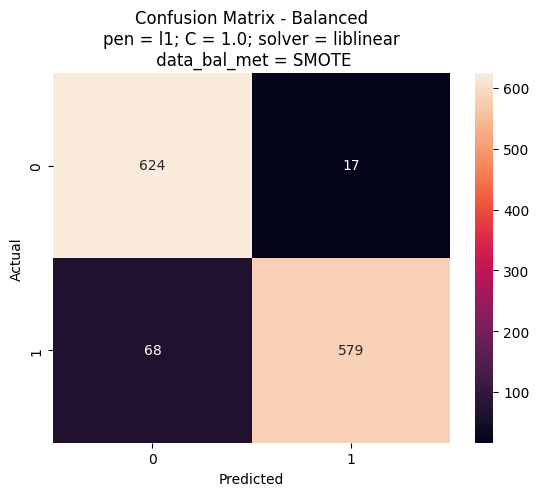

In [150]:
# Use the model to make predictions on the testing data
y_pred = log_reg.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Classification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix,"\n")

# Visualizing confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
title = 'Confusion Matrix - Balanced\npen = ' + pen + '; C = ' + str(reg) + '; solver = ' + solv + '\n data_bal_met = ' + data_bal_met
plt.title(title)

plt.show()

In [151]:
## CONSTANTS
pen = 'l2'
reg = 1.0
solv = 'liblinear'
##

# Training logistic regression model, with L2 instead
log_reg = LogisticRegression(penalty=pen, C=reg, solver=solv)
  #L1 to help with feature selection
  #C=1 is moderate regularization
  #liblinear is good for binary outcomes
log_reg.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       641
           1       0.97      0.90      0.93       647

    accuracy                           0.93      1288
   macro avg       0.94      0.93      0.93      1288
weighted avg       0.94      0.93      0.93      1288


Confusion Matrix:
[[622  19]
 [ 66 581]] 



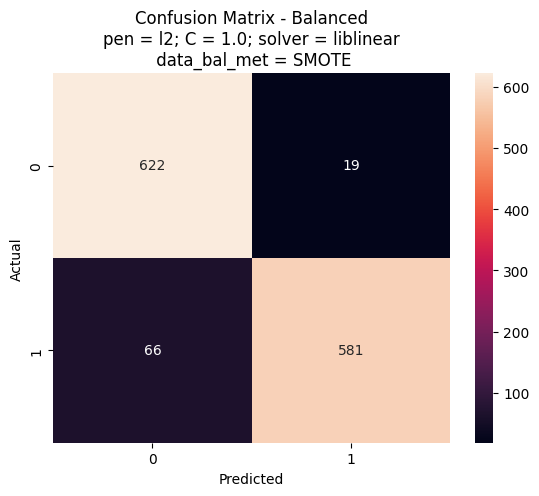

In [152]:
# Use the model to make predictions on the testing data
y_pred = log_reg.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Classification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix,"\n")

# Visualizing confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
title = 'Confusion Matrix - Balanced\npen = ' + pen + '; C = ' + str(reg) + '; solver = ' + solv + '\n data_bal_met = ' + data_bal_met
plt.title(title)

plt.show()

In [153]:
### model summary

import statsmodels.api as sm
import pandas as pd

# Separate features and target variable
X = data_ups.drop('stroke', axis=1)
y = data_ups['stroke']

# Add a constant term for the intercept
X = sm.add_constant(X)

# Create and fit logistic regression model
log_reg = sm.Logit(y, X).fit()

# Get summary report
summary = log_reg.summary()
print(summary)

         Current function value: 0.159180
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 stroke   No. Observations:                 6436
Model:                          Logit   Df Residuals:                     6419
Method:                           MLE   Df Model:                           16
Date:                Mon, 02 Oct 2023   Pseudo R-squ.:                  0.7704
Time:                        16:32:20   Log-Likelihood:                -1024.5
converged:                      False   LL-Null:                       -4461.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     59.2628   3.89e+05      0.000      1.000   -7.63e+05    7.63e+05
gender                    -1.